In [1]:
import numpy as np
# import h5py

In [ ]:
######## Check ########
d = np.arange(100)
with h5py.File('name-of-file.h5', 'w') as hf:
  dset = hf.create_dataset("name-of-dataset", shape=(16000, 72), dtype=np.float32)

  for i in range(16000):
    dset[i, :] = np.arange(72)
  
with h5py.File('name-of-file.h5', 'r') as f:
    my_array = f['name-of-dataset'][()]

In [ ]:
my_array.shape

(16000, 72)

In [9]:
!pip install turbustat

     |████████████████████████████████| 3.0MB 8.1MB/s 
     |████████████████████████████████| 225kB 35.4MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 


In [10]:
import os
import shutil

import numpy as np
import cv2

from turbustat.statistics import PowerSpectrum
from astropy.io import fits
import astropy.units as u

import matplotlib.pyplot as plt

from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!unzip drive/MyDrive/dataset_zurich

In [4]:
DATASET_ROOT = "dataset_zurich/"
NEW_DATASET_ROOT = "data/"

if not os.path.isdir("data"):
		os.mkdir("data")
if not os.path.isdir("data/noninteracting"):
  os.mkdir("data/noninteracting")
if not os.path.isdir("data/merger"):
  os.mkdir("data/merger")

src_train_merger = DATASET_ROOT + "merger/training"
src_val_merger = DATASET_ROOT + "merger/validation"
src_test_merger = DATASET_ROOT + "merger/test"
src_train_noninteracting = DATASET_ROOT + "noninteracting/training"
src_val_noninteracting = DATASET_ROOT + "noninteracting/validation"
src_test_noninteracting = DATASET_ROOT + "noninteracting/test"

dest_merger = NEW_DATASET_ROOT + "merger/"
dest_noninteracting = NEW_DATASET_ROOT + "noninteracting/"

for filename in os.listdir(src_train_merger):
  shutil.move(os.path.join(src_train_merger, filename), dest_merger)
for filename in os.listdir(src_val_merger):
  shutil.move(os.path.join(src_val_merger, filename), dest_merger)
for filename in os.listdir(src_test_merger):
  shutil.move(os.path.join(src_test_merger, filename), dest_merger)

for filename in os.listdir(src_train_noninteracting):
  shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_val_noninteracting):
  shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_test_noninteracting):
  shutil.move(os.path.join(src_test_noninteracting, filename), dest_noninteracting)

try:
  os.rmdir(DATASET_ROOT)  # TODO: Raises error if directory is not empty.
except OSError:
  !rm -rf DATASET_ROOT

In [5]:
%time
original_image = cv2.imread("/content/data/noninteracting/587722952767439411.jpeg", 0)
# original_image = original_image.mean(axis=2)
# original_image.shape
# resized_image = cv2.resize(original_image, (100, 100), 
                          #  interpolation=cv2.INTER_NEAREST)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


In [33]:
!rm -rf __MACOSX/

In [35]:
OUTPUT_DIR = "spectrums/"
os.mkdir(OUTPUT_DIR)
os.mkdir(os.path.join(OUTPUT_DIR, "merger"))
os.mkdir(os.path.join(OUTPUT_DIR, "noninteracting"))

In [36]:
# # Using joblib
from tqdm.auto import tqdm
from joblib import Parallel, delayed

# data_ = np.empty((0, 72))  # 72 needs to be changed if image size is resized to a different value.

# from PIL import Image
NEW_DATASET_ROOT = "data/"
def calc_spectrum(img_path, size=100):
  """
  img_path: Full path to the image.
  size: Size to resize each image, defaults to 100, i.e. 100X100.

  """
  img = cv2.imread(img_path, 0)
  img = cv2.resize(img, (size, size))
  # img = img.mean(axis=2)

  # Compute Power Spectrum.
  pspec = PowerSpectrum(img, header=fits.header.Header())

  try:  # Some values in the 1D averaged spectrum could be infinite which raises error in the `.run` method.
    pspec.run(verbose=False)
    ps1d = pspec.ps1D
  except ValueError:
    print(f"The power spectrum of the image '{img_path}' has infinite values. Ignoring...")
    ps1d = np.zeros(72)
  
  if img_path.split("/")[-1].split(".")[1] == "noninteracting":
    np.save(os.path.join(OUTPUT_DIR, "noninteracting", img_path.split("/")[-1].split(".")[0]+".npy"), ps1d)
  else:
    np.save(os.path.join(OUTPUT_DIR, "merger", img_path.split("/")[-1].split(".")[0]+".npy"), ps1d)

def _get_img_paths():
  for class_ in os.listdir(NEW_DATASET_ROOT):
    class_path = os.path.join(NEW_DATASET_ROOT, class_)
    for image in os.listdir(class_path):
      yield os.path.join(class_path, image)

# paths = list(_get_img_paths())

_ = Parallel(n_jobs=-1)(delayed(calc_spectrum)(img_path) for img_path in tqdm(_get_img_paths(), total=16000))
# for img_path in tqdm(_get_img_paths(), total=16000):
  # _ = calc_spectrum(img_path)

# def save_spectrum(img_path):


# with h5py.File('Spectrum_1D_data.h5', 'w') as hf:
#   dset = hf.create_dataset("_Spectrum_", shape=(16000, 73), dtype=np.float32)

#   for i, img_path in tqdm(enumerate(_get_img_paths()), total=16000):
#     ps1d = calc_spectrum(img_path, NEW_DATASET_ROOT)
#     label = 0 if img_path.split("/")[1] == "noninteracting" else 1

#     dset[i, :-1] = ps1d
#     dset[:, -1] = label
  
# with h5py.File('Spectrum_1D_data.h5', 'r') as f:
#     data = f['_Spectrum_'][()]

# np.save("SPECTRUM_DATA.npy", data_)

In [41]:
d = np.load("/content/spectrums/merger/587725469061283965.npy")
d.shape

(72,)

In [56]:
# To solve the previous bug of transfering all files to the merger folder
for file_ in os.listdir("spectrums/merger"):
  if os.path.exists(os.path.join("data/noninteracting", file_.split(".")[0]+".jpeg")):
    shutil.move(os.path.join("spectrums/merger", file_), os.path.join("spectrums/noninteracting", file_))

In [58]:
!ls spectrums/noninteracting | wc -l

10000


In [59]:
!ls spectrums/merger | wc -l

6000


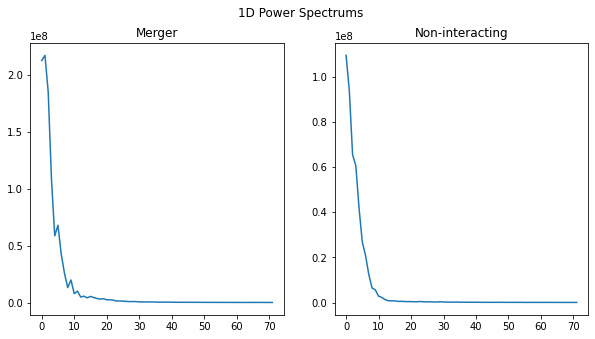

In [66]:
merger_spec = np.load("/content/spectrums/merger/587722983366262870.npy")
noninterac_spec = np.load("/content/spectrums/noninteracting/587724232642723967.npy")

fig, axes = plt.subplots(1, 2, figsize=(10, 5));
fig.suptitle("1D Power Spectrums");
axes[0].plot(merger_spec);
axes[0].set_title("Merger");
axes[1].plot(noninterac_spec);
axes[1].set_title("Non-interacting");

In [ ]:
!zip -r all_spectrums.zip spectrums

In [61]:
# f = h5py.File('Spectrum_1D_data.h5', 'r')

In [62]:
# f.keys()

In [63]:
# n1 = f.get("_Spectrum_")
# np.array(n1)